In [1]:
import sys
from pathlib import Path
sys.path.append(f'{str(Path.home())}/intelligent_system_tools/twitter_final_project/data')

# numpy and pandas for data manipulation
import pandas as pd 
import numpy as np
pd.options.mode.chained_assignment = None # no warnings

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# wordcloud for visualization
from wordcloud import WordCloud

# preprocessing external lib
from text_processing import text_processing

## Load Data
Load `train.csv` and `test.csv` using read_csv()

In [2]:
# reading in the CSV files using the pandas read_csv function. we have also dropped the id column from the train set as we won’t need this for training the model.
train = pd.read_csv('./data/train.csv').drop('id', axis=1)
test = pd.read_csv('./data/test.csv')

## Data Preprocessing
Using the following text preprocessing methods: <br>
[1] Format text: correct spelling, remove emojis, and remove stop_words <br>
[2] Format keyword: fill missing keywords for certain tweets following specific scenarios <br>
[3] Format location: fill missing locations for certain tweets following specific scenarios <br>

** For deatils per each scenario, please follow the text_processing documentation

In [3]:
#train_clean = text_processing(train)
#test_clean = text_processing(test)
#train_clean.to_csv('./Data/train_clean.csv', index=False)
#test_clean.to_csv('./Data/test_clean.csv', index=False)
train_clean = pd.read_csv('./data/train_clean.csv')
test_clean = pd.read_csv('./data/test_clean.csv')

In [4]:
# searching for duplicated tweets with different target and removing them
df_mislabeled = train_clean.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
train_clean = train_clean[~train_clean['text'].isin(df_mislabeled.index.tolist())]
# removing tweets that have less than 3 words
train_clean = train_clean[train_clean['text'].apply(lambda x: len(x) >= 3)]

## GRAPHS

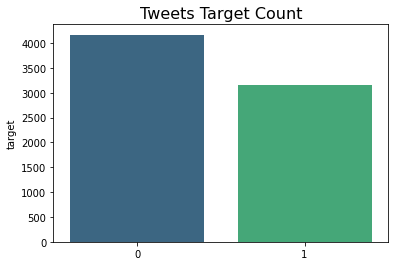

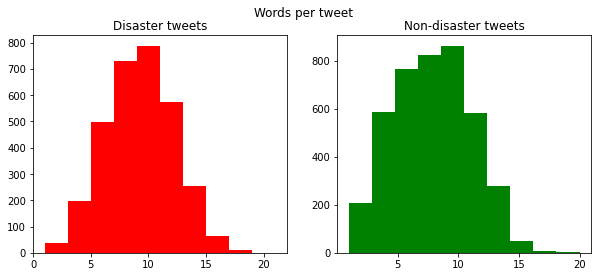

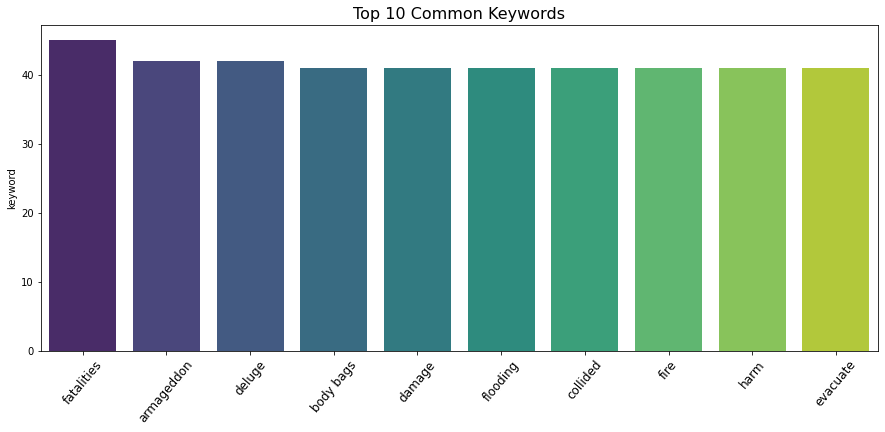

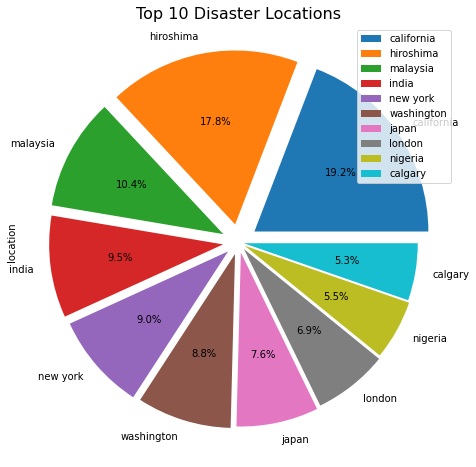

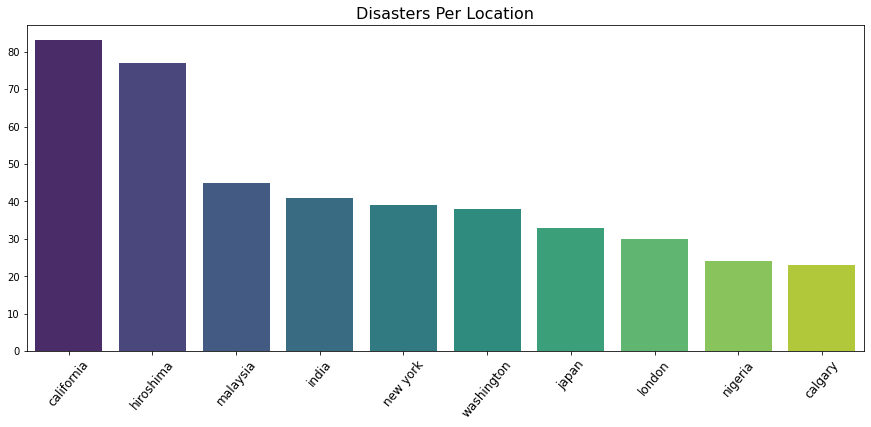

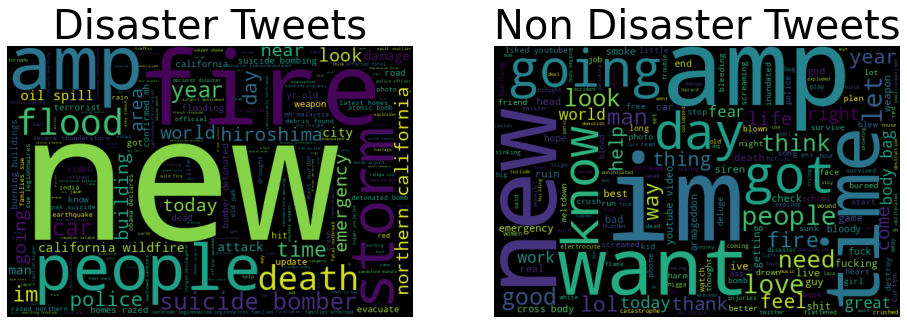

In [5]:
# tweets target count
count_target = train_clean['target'].value_counts().to_frame()
sns.barplot(data=count_target, x=count_target.index, y="target", palette="viridis")
plt.title("Tweets Target Count", size=16)
plt.show()

# PLOTTING WORD-COUNT
train_clean['word_count'] = train_clean['text'].apply(lambda x: len(str(x).split()))
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=train_clean[train_clean['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=train_clean[train_clean['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

# top 10 common keywords
common_keywords = train_clean["keyword"].value_counts()[:10].to_frame()
fig = plt.figure(figsize=(15,6))
sns.barplot(data=common_keywords, x=common_keywords.index, y="keyword", palette="viridis")
plt.title("Top 10 Common Keywords", size=16)
plt.xticks(rotation=50, size=12)
plt.show()

# top 10 disaster locations
top_10_disaster_locations = train_clean['location'][train_clean['target']==1].value_counts().to_frame()[:10]
top_10_disaster_locations.plot(kind='pie', y='location', figsize=(8, 8), explode=(0.11,0.105,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03), autopct='%1.1f%%')
plt.title('Top 10 Disaster Locations', size=16) 
plt.show()

# disaster per location
a = plt.figure(figsize=(15,6))
a = sns.barplot(data=top_10_disaster_locations, x=top_10_disaster_locations.index, y="location", palette="viridis")
a.set(ylabel=None)
plt.title("Disasters Per Location", size=16)
plt.xticks(rotation=50, size=12)
plt.show()

# word cloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 8])
## disaster tweets
disaster_tweets = train_clean[train_clean['target']==1]['text']
wordcloud1 = WordCloud(background_color='black', width=600, height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets', fontsize=40)
## non disaster tweets
non_disaster_tweets = train_clean[train_clean['target']==0]['text']
wordcloud2 = WordCloud(background_color='black', width=600, height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40)
plt.show()

## Scikit-pipeline
Next, we will create a scikit-pipeline with following methods:<br>
[1] CountVectorizer() - split data into tokens, or individual words, count the frequency in which each word appears in the  text, and then represent theses counts as a sparse matrix <br>
[2] TfidfTransformer() - apply a weightning to the word counts produced by CountVectorizer(), this weightning is to scale down impact of very frequently occuring words in the text <br>
[3] LogisticRegression() - generally regarded as one of the best text classification algorithms

In [86]:
X = train_clean.drop('target', axis = 1)
y = train_clean['target']
X_train, X_test, y_train, y_test  = train_test_split(X['text'], y, test_size=0.2, shuffle=True, random_state=4)

## Logistic Regression

In [87]:
pipeline_LR = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', LogisticRegression())
])
model = pipeline_LR.fit(X_train, y_train)

y_predict = model.predict(X_test)
target_names = ['Non-disaster Tweet', 'Disaster Tweet']
print(classification_report(y_test, y_predict, target_names=target_names))

                    precision    recall  f1-score   support

Non-disaster Tweet       0.79      0.92      0.85       811
    Disaster Tweet       0.88      0.69      0.77       654

          accuracy                           0.82      1465
         macro avg       0.83      0.81      0.81      1465
      weighted avg       0.83      0.82      0.81      1465



## Submission

In [52]:
submission_test_clean = test_clean.copy()['text'].fillna(' ')
submission_test_pred = pipeline_LR.predict(submission_test_clean)
id_col = test['id']
submission_df_1 = pd.DataFrame({"id": id_col,
                               "target": submission_test_pred})
submission_df_1.to_csv('submission_1.csv', index=False)